In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        TabularQLearner(
            lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.98
        )
        for i in range(population)
    ]

    # agents[0] = TitForTat()
    # agents[16] = TitForTat()
    # agents[16] = TitForTat()
    # agents[31] = TitForTat()

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/50000 [00:00<?, ?it/s]

BEST AGENT: 297410 (0.8044602483994222, CDCDCDCDCCCCCCCC)
WORST AGENT: 219067 (0.7073539129613896, CDCDCDCDCDCDCDCD)


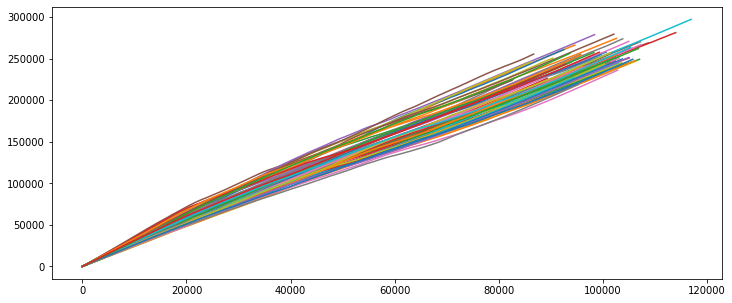

In [7]:
POPULATION = (8, 8)
ROUNDS = 50_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    # TODO: maybe I should switch to mean rewards (?)
    # mean_rewards = [(i, np.mean(history)) for i, history in enumerate(sim.reward_histories)]
    # mean_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT: {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT: {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

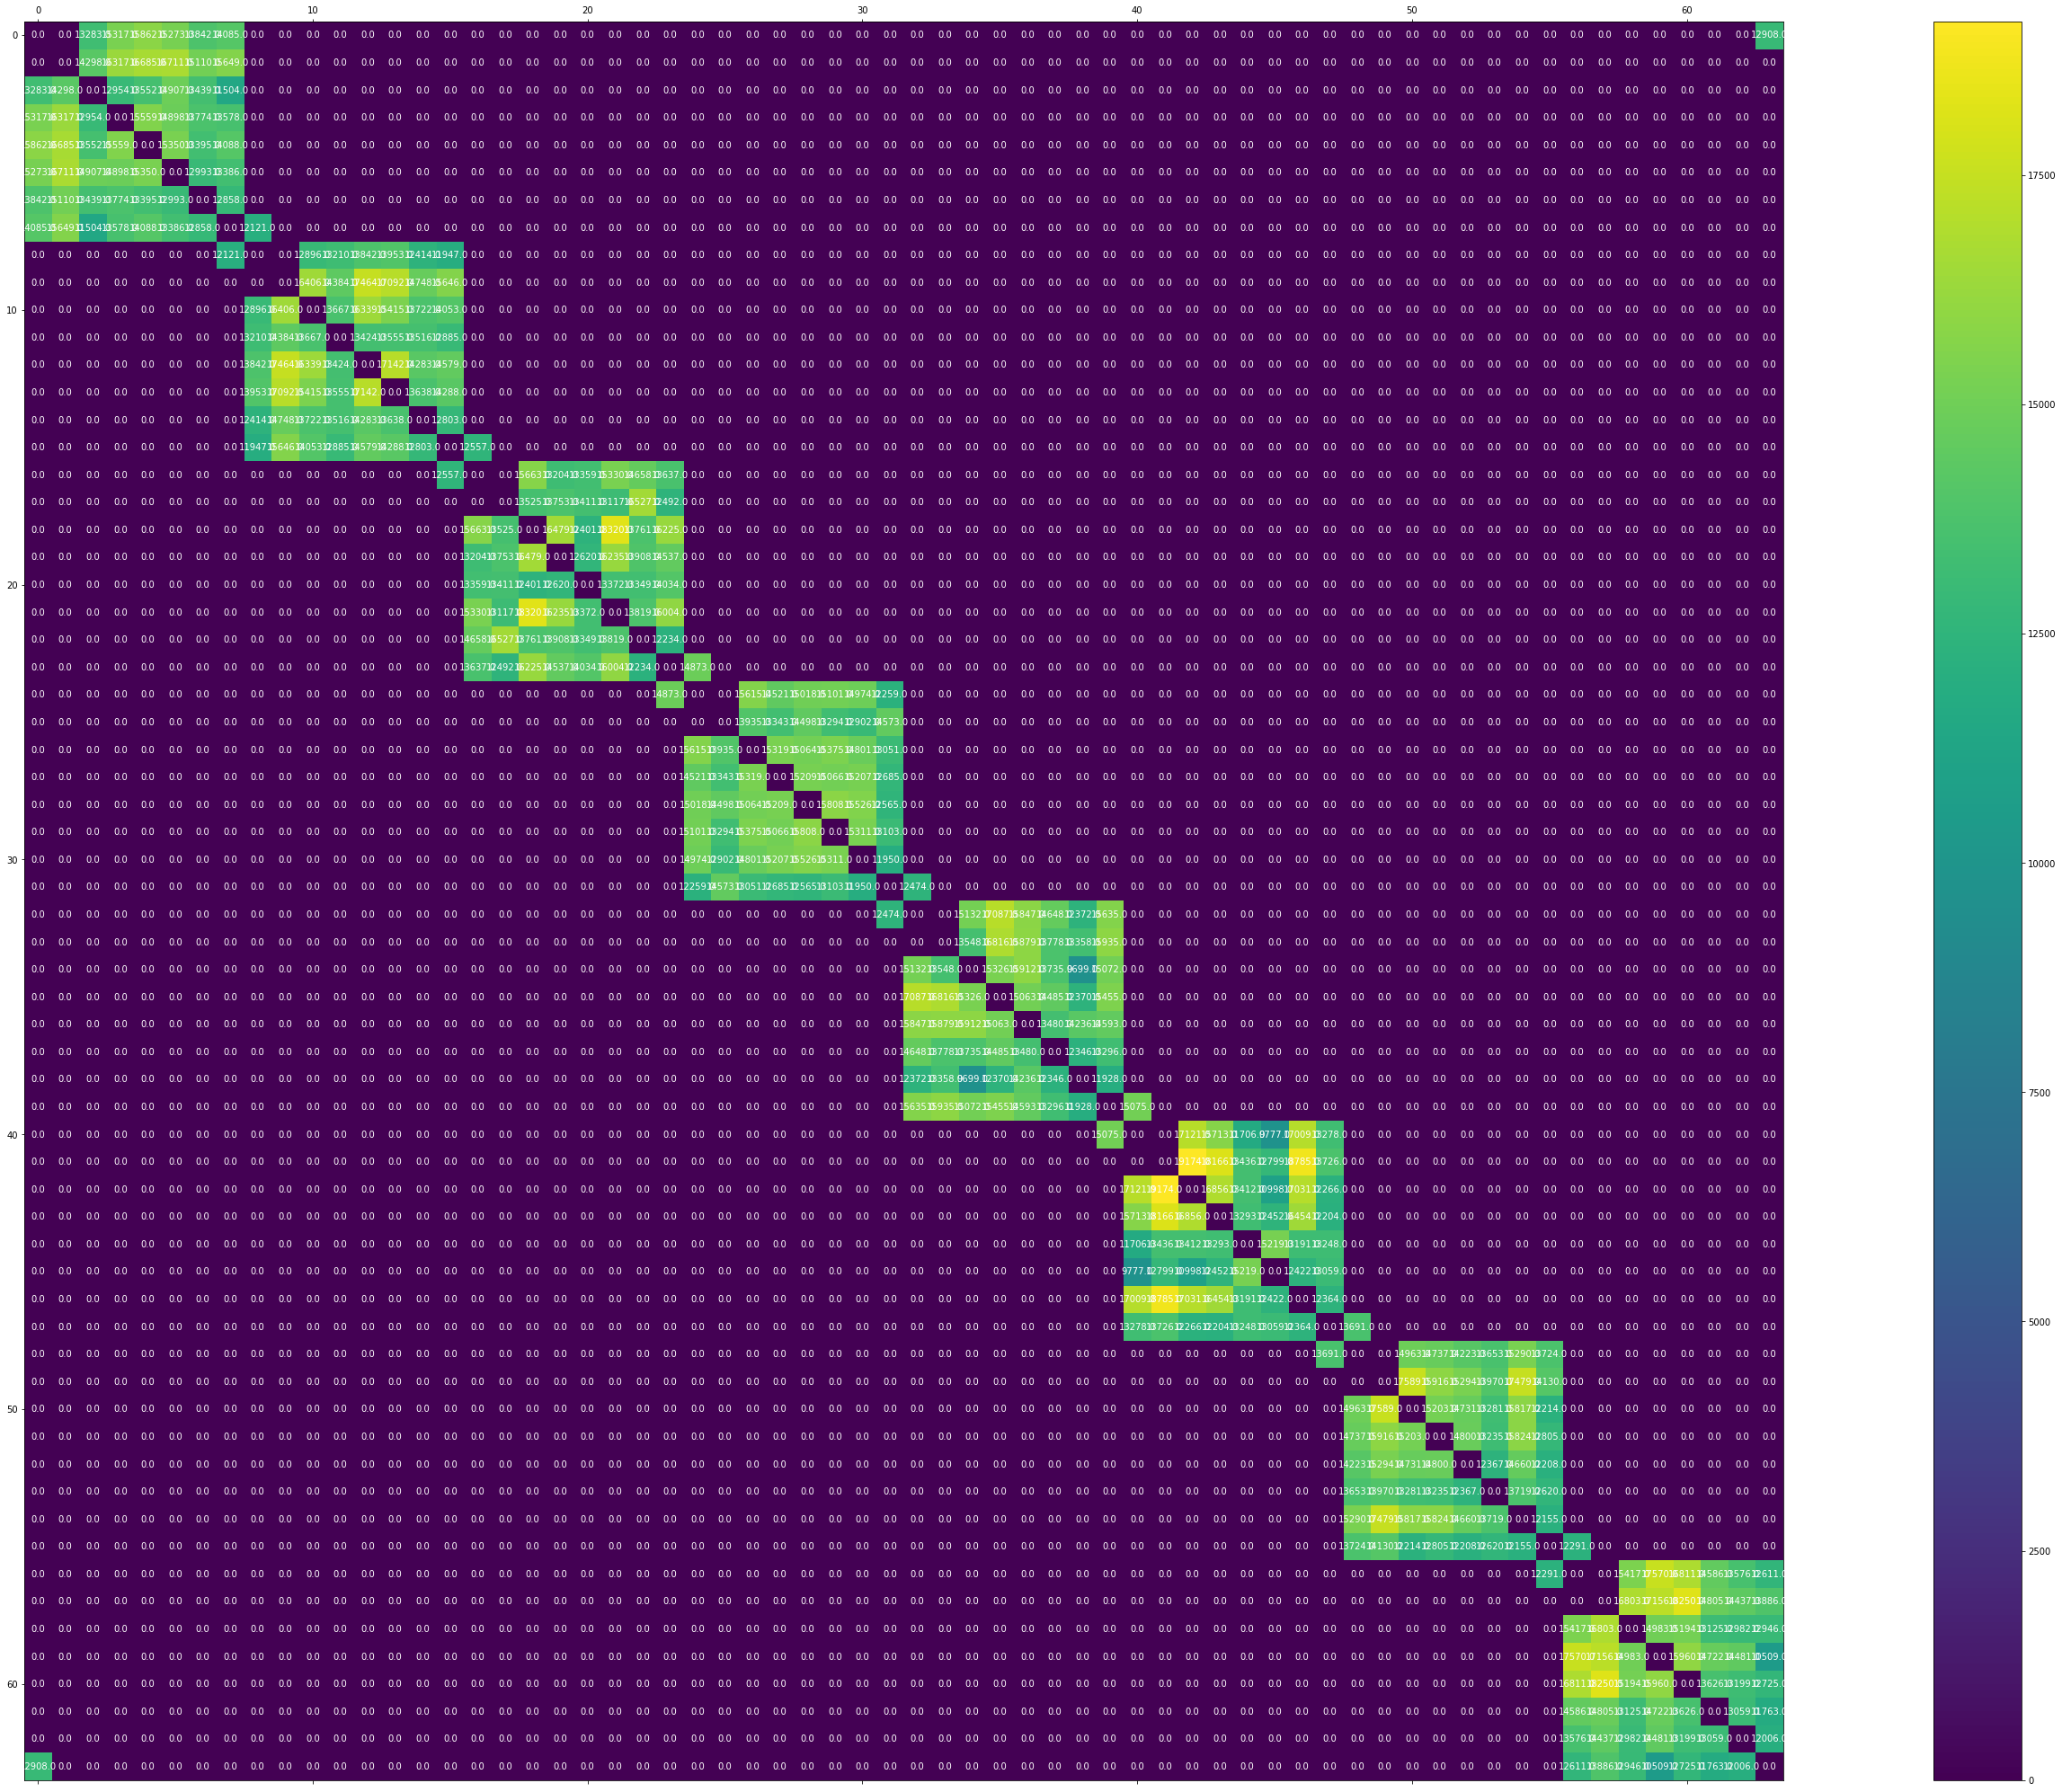

In [23]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [8]:
sim.calculate_weights()

[[0.496823006850862,
  0.5006659267480578,
  0.6939982347749338,
  0.6562757807896288,
  0.44402542985117754,
  0.5332268370607028,
  0.4859621939882244],
 [0.5024339068401175,
  0.5117791260648403,
  0.629997003296374,
  0.6205553228412423,
  0.4526141628060887,
  0.5581762412933734],
 [0.496823006850862,
  0.5024339068401175,
  0.43433688436004325,
  0.6194805194805194,
  0.7082377406587509,
  0.41416027978272196,
  0.47934631432545205],
 [0.5006659267480578,
  0.5117791260648403,
  0.43433688436004325,
  0.5715598688861752,
  0.5516713652839307,
  0.43911717729054744,
  0.46728531447930477],
 [0.6939982347749338,
  0.629997003296374,
  0.6194805194805194,
  0.5715598688861752,
  0.6954397394136808,
  0.47887271369914153,
  0.5794151050539467],
 [0.6562757807896288,
  0.6205553228412423,
  0.7082377406587509,
  0.5516713652839307,
  0.6954397394136808,
  0.4648887862695298,
  0.5267891827282235],
 [0.44402542985117754,
  0.4526141628060887,
  0.41416027978272196,
  0.4391171772905474

In [9]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Ac

In [10]:
cumulative_rewards[0][0]

39

In [11]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[132.69822395 132.39989349]
  [131.85559841 132.61469502]
  [131.19466205 128.12306468]
  [124.64850528 131.60088028]]

 [[132.42376755 131.70199277]
  [124.10770613 132.61120567]
  [130.96431382 128.88082577]
  [125.74665798 132.20895259]]

 [[132.67483116 131.22354243]
  [132.85998425 132.43370178]
  [129.53588151 102.15844466]
  [130.21946422 106.34083138]]

 [[132.72891451 125.85532782]
  [132.48115724 123.52575067]
  [132.22846482 100.54886587]
  [131.76973516  98.76848537]]]


In [12]:
agents[1]._q_table

array([[[131.38713036, 128.01040462],
        [113.6198842 , 131.61658727],
        [129.83806093, 119.34594764],
        [114.53898286, 126.95775179]],

       [[128.85476507, 112.885732  ],
        [ 98.22937513, 112.36902148],
        [129.69776578, 124.09120576],
        [110.61558331, 125.84362534]],

       [[127.99197772, 131.05563362],
        [126.36148474, 131.69064847],
        [124.86366124,  97.94384285],
        [126.65117203, 107.41892232]],

       [[128.5741483 , 110.99673728],
        [107.58088415, 131.15828381],
        [128.17360799, 109.93012107],
        [127.30801865, 112.34976764]]])

In [13]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [14]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [15]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

2.0                      CDCCCDCDCCCCCCCC
3.0                      CDCCDDCCCDCCCDCC
4.0                      DDCDCDCCCCDDCDDC
5.0                      CDCDCDCDCDDDCDCC
6.0                      CDDDCDDDCCCDDDCD
7.0                      CDCDCDCDCCCCCCCC
8.0                      CCDCCDCDDCCCCDDD
9.0                      DDCCCDCDCDCCCCCC
10.0                     CCDCDDCCCCCDCDCC
11.0                     DCCDDDCDCDCCCCCC
12.0                     DCDDDDCCDDDDDDCD
14.0                     CCCDCDCDCDCCCCCC
15.0                     DCCDDDCDCCCCCCCC
16.0                     DCCDCDCDDDCDDDCD
17.333333333333332       CDCDCDCDCDCCCCCC
18.0                     CCCDCDCCCCCDDCCD
19.0                     CDCDCDCCCDCCCCCC
20.0                     CDCCCDCDCDCDCDCC
21.0                     CCCDCDCCDCDDDCCC
22.0                     DCCCDCDCDCCCDCCD
24.0                     DDCCDDCCCDCCCDCC
25.0                     CCDCCDDCCCCDCCCC
26.0                     CDCCCDCDCCCDCDCC
31.0                     CDCCDDCDC

In [16]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

281426.0                 CDCCCDCDCCCCCCCC
280696.0                 CDCDCDCDCCCCCCCC
279570.0                 CDCCDDCCCDCCCDCC
278979.0                 DDCDCDCCCCDDCDDC
274622.0                 CDCDCDCDCDDDCDCC
273995.0                 CDDDCDDDCCCDDDCD
270460.0                 CCDCCDCDDCCCCDDD
269339.0                 DDCCCDCDCDCCCCCC
269072.0                 CCDCDDCCCCCDCDCC
266673.0                 DCCDDDCDCDCCCCCC
266349.0                 DCDDDDCCDDDDDDCD
262264.0                 CCCDCDCDCDCCCCCC
261463.0                 DCCDDDCDCCCCCCCC
261185.0                 DCCDCDCDDDCDDDCD
260636.66666666666       CDCDCDCDCDCCCCCC
257836.0                 CCCDCDCCCCCDDCCD
257545.0                 CDCDCDCCCDCCCCCC
257096.0                 CDCCCDCDCDCDCDCC
256693.0                 CCCDCDCCDCDDDCCC
255621.0                 DCCCDCDCDCCCDCCD
255476.0                 DDCCDDCCCDCCCDCC
255146.0                 CCDCCDDCCCCDCCCC
254685.0                 CDCCCDCDCCCDCDCC
250991.0                 CDCCDDCDC

In [17]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CDCDCDCDCCCCCCCC'

In [18]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    agents[cumulative_rewards[0][0]]._q_table

In [19]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => D
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => D
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => D
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => D
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
